<a href="https://colab.research.google.com/github/No1377/-/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
data = pd.read_csv('/content/drive/MyDrive/data2_full_10000n.csv')
df2 = pd.read_excel("/content/drive/MyDrive/جدول مرگ و میر ایران.xlsx")

number_of_data = len(data['Age'])
print(data)
# تابع تخفیف
def d(v, k):
    return (1 / (1 + v)) ** k

v = 0.1

# تابع محاسبه احتمال زنده ماندن
def p(x, k):
    t = 1
    for i in range(0, k):
        t *= df2["p_x"][x + i]
    return t

# تابع تعدیل احتمال
def p_star(x, k, landa):
    return float(norm.cdf(norm.ppf(p(x, k)) - landa))

# تابع محاسبه احتمال مرگ
def q(x, k):
    return 1 - p(x, k)

# تابع تعدیل احتمال مرگ
def q_star(x, k, landa):
    return 1 - p_star(x, k, landa)

      Gender  Age  Smoker  Disease  Jobs  Benefit  Duration     Premuim  \
0          0   55       1        0     0      739         3    6.809303   
1          1   75       1        1     1     4267         5  415.161618   
2          0   52       1        0     0      746        28   11.021023   
3          0   23       1        0     1     5985        54   27.919633   
4          0   10       0        0     0     6769         7   17.098726   
...      ...  ...     ...      ...   ...      ...       ...         ...   
9995       1   70       1        1     1     4643        10  338.066638   
9996       0   38       1        0     0     6676        42   46.097466   
9997       1   31       1        1     1     7437        49   54.901634   
9998       1   64       0        1     1     4994         1  129.652353   
9999       0   43       0        0     0     9526        11   45.765155   

         landa  
0     0.156738  
1     0.384277  
2     0.141113  
3     0.340332  
4     0.477051

In [ ]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
import xgboost as xgb
import sklearn
print(f"XGBoost version: {xgb.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

XGBoost version: 2.1.3
Scikit-learn version: 1.6.0


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# داده نمونه
X = np.random.rand(100, 7)
y = np.random.rand(100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# مدل XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# پیش‌بینی
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

MSE: 0.11495798300119635


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np

def update_X_Y_and_optimize_landa_with_xgboost(data):
    X = np.array([data['Gender'],
                  data['Age'],
                  data['Smoker'],
                  data['Jobs'],
                  data['Disease'],
                  data['Duration'],
                  data['Benefit']]).T
    y = data['landa']

    # تقسیم داده‌ها به آموزش و تست
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # اضافه کردن نویز به داده‌های آموزشی
    X_train_noisy = X_train + np.random.normal(0, 0.05, X_train.shape)

    # تنظیمات جستجوی پارامترها
    param_dist = {
        'max_depth': range(2, 5),
        'learning_rate': [0.05, 0.1],
        'n_estimators': range(50, 150, 50),
        'subsample': [0.6, 0.7],
        'colsample_bytree': [0.6, 0.7],
        'reg_alpha': [1, 10],
        'reg_lambda': [10, 50]
    }

    # تعریف مدل و جستجوی پارامتر
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train_noisy, y_train)

    # بهترین پارامترها
    best_params = random_search.best_params_
    print("Best Parameters:", best_params)

    # آموزش مدل با بهترین پارامترها
    best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
    best_model.fit(X_train_noisy, y_train)

    # پیش‌بینی و محاسبه MSE
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error (XGBoost):", mse)

    def predict_landa(gender, age, smoker, job, disease, duration, benefit):
        input_data = np.array([[gender, age, smoker, job, disease, duration, benefit]])
        predicted_landa = best_model.predict(input_data)
        return predicted_landa[0]

    return predict_landa, best_model

# بهینه‌سازی λ و آماده‌سازی مدل XGBoost
predict_landa_xgb, best_model_xgb = update_X_Y_and_optimize_landa_with_xgboost(data)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
!pip install scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 24.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
!kill -9 -1

In [ ]:


def update_X_Y_and_optimize_landa_with_xgboost(data):
    X = np.array([data['Gender'],
                  data['Age'],
                  data['Smoker'],
                  data['Jobs'],
                  data['Disease'],
                  data['Duration'],
                  data['Benefit']]).T
    y = data['landa']

    # تقسیم داده‌ها به آموزش و تست
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # اضافه کردن نویز به داده‌های آموزشی
    X_train_noisy = X_train + np.random.normal(0, 0.05, X_train.shape)

    # تنظیمات ساده برای جلوگیری از Overfitting
    param_dist = {
        'max_depth': range(2, 5), # عمق کمتر برای کاهش پیچیدگی
        'learning_rate': [0.05, 0.1], # کاهش نرخ یادگیری
        'n_estimators': range(50, 150, 50), # کاهش تعداد استیماتورها
        'subsample': [0.6, 0.7], # انتخاب بخشی از داده‌ها
        'colsample_bytree': [0.6, 0.7], # انتخاب بخشی از ویژگی‌ها
        'reg_alpha': [1, 10], # افزایش جریمه L1
        'reg_lambda': [10, 50] # افزایش جریمه L2
    }

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # جستجوی تصادفی برای یافتن بهترین پارامترها
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=20, # تعداد تکرار جستجو کمتر
        cv=3, # تعداد folds کمتر
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train_noisy, y_train)
    best_params = random_search.best_params_

    # تنظیم پارامترهای بهینه
    params = {
        'max_depth': best_params['max_depth'],
        'learning_rate': best_params['learning_rate'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'reg_alpha': best_params['reg_alpha'],
        'reg_lambda': best_params['reg_lambda'],
        'objective': 'reg:squarederror'
    }

    # تبدیل داده‌ها به DMatrix
    dtrain = xgb.DMatrix(X_train_noisy, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # آموزش مدل نهایی با Early Stopping
    best_model = xgb.train(
        params,
        dtrain,
        num_boost_round=150,
        evals=[(dtest, "Test")],
        early_stopping_rounds=5, # توقف زودهنگام
        verbose_eval=False
    )

    # پیش‌بینی و محاسبه MSE
    y_pred = best_model.predict(dtest)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error (XGBoost):", mse)

    def predict_landa(gender, age, smoker, job, disease, duration, benefit):
        input_data = np.array([[gender, age, smoker, job, disease, duration, benefit]])
        dinput = xgb.DMatrix(input_data)
        predicted_landa = best_model.predict(dinput)
        return predicted_landa[0]

    return predict_landa, best_model

# بهینه‌سازی λ و آماده‌سازی مدل XGBoost
predict_landa_xgb, best_model_xgb = update_X_Y_and_optimize_landa_with_xgboost(data)

Mean Squared Error (XGBoost): 0.00018028073663862965


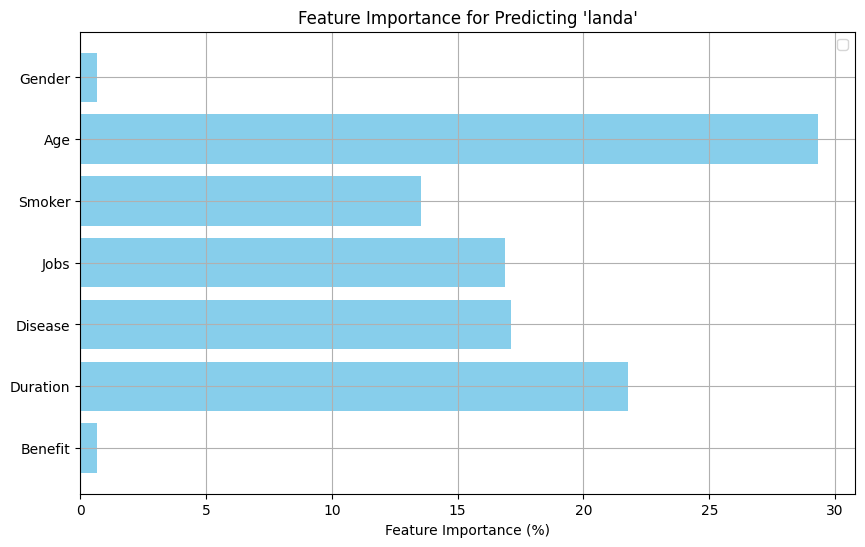

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# استخراج اهمیت ویژگی‌ها از مدل XGBoost
feature_importances = best_model_xgb.get_score(importance_type='weight')
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# لیست نام ویژگی‌ها و اهمیت آن‌ها
features = ['Gender', 'Age', 'Smoker', 'Jobs', 'Disease', 'Duration', 'Benefit']
importance_values = [feature_importances.get(f'f{i}', 0) for i in range(len(features))]

# محاسبه درصد اهمیت هر ویژگی
importance_percentages = 100 * np.array(importance_values) / np.sum(importance_values)

# ترسیم نمودار میله‌ای اهمیت ویژگی‌ها
plt.figure(figsize=(10, 6))
plt.barh(features, importance_percentages, color='skyblue')
plt.xlabel("Feature Importance (%)")
plt.title("Feature Importance for Predicting 'landa'")
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.savefig("chart.png")
plt.show()
files.download("chart.png")

In [ ]:
landa_new = predict_landa_xgb(0,70, 1,1, 1, 5, 5000)
print("Optimized Predicted Landa:", landa_new)

Optimized Predicted Landa: 0.35955563


In [ ]:
landa=0.35955563
gender= 0
age=70
smoker=1
job=1
disease=1
duration=5
benefit=5000

In [ ]:
t=0
z=0
for k in range(0,duration):
   t+= d(v,k+1) * p(age,k) * q(age+k,1)

Ax=t


r=0
for k in range(0,duration):
   r+= d(v,k) * p(age,k)
ax=r

G = (Ax/ax) * benefit
G_all = G + 0.002 * benefit + G * 0.2 * smoker + G * 0.5 * disease + G * 0.3 * job
print(G_all)
print(G)

301.91763754361057
145.95881877180528


In [ ]:
t=0
z=0
for k in range(0,duration):
   t+= d(v,k+1) * p_star(age,k,landa) * q_star(age+k,1,landa)

Ax_star=t


r=0
for k in range(0,duration):
   r+= d(v,k) * p_star(age,k,landa)
ax_star=r

G_star = (Ax_star/ax_star) * benefit
print(G_star)

307.1866694275198


In [ ]:
def G_all(Age,Smoker,Job,Disease,Duration,Benefit):
     t=0
     z=0
     for k in range(0,Duration):
        t+= d(v,k+1) * p(Age,k) * q(Age+k,1)

     Ax=t


     r=0
     for k in range(0,Duration):
       r+= d(v,k) * p(Age,k)
     ax=r

     G = (Ax/ax) * Benefit
     G_all = G + Benefit * 0.002 + G * 0.2 * Smoker + G * 0.5 * Disease + G * 0.3 * Job
     return G_all

In [ ]:
def G_star(Age,Duration,Benefit,landa):
     t=0
     z=0
     for k in range(0,Duration):
        t+= d(v,k+1) * p_star(Age,k,landa) * q_star(Age+k,1,landa)

     Ax_star=t


     r=0
     for k in range(0,Duration):
       r+= d(v,k) * p_star(Age,k,landa)
     ax_star=r

     G_sta = (Ax_star/ax_star) * Benefit
     return G_sta

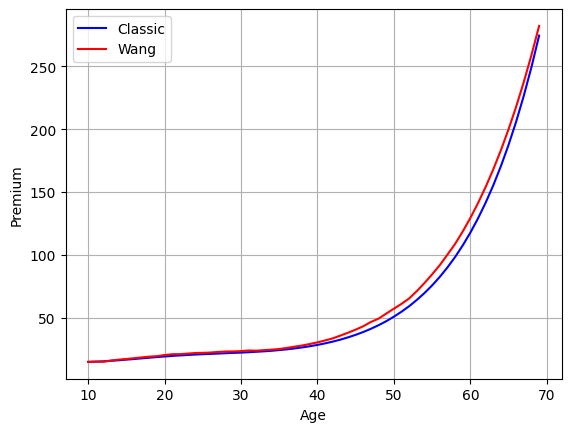

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
A=[]
B=[]
C=[]
for j in range(10,70):
    A.append(j)
    landa = predict_landa_xgb(1,j, 1, 1, 1, 5, 5000)
    b=G_all(j,1,1,1,5,5000)
    B.append(b)
    c=G_star(j,5,5000,landa)
    C.append(c)
fig, ax1= plt.subplots()
ax1.plot(A,B,'blue',label='Classic')
ax1.plot(A,C,'red',label='Wang')
plt.xlabel("Age")
plt.ylabel("Premium")
plt.legend()
plt.grid(True)
plt.savefig("chart.png")
plt.show()
files.download("chart.png")

In [ ]:
#import random
# تولید داده فرضی 100 تایی با شرایط جدید
num_samples = 10000
gender_random = np.random.randint(0, 2, num_samples)
age_random = np.random.randint(5, 79, num_samples)
smoker_random = np.random.randint(0, 2, num_samples)
job_random = np.random.randint(0, 2, num_samples)
disease_random = np.random.randint(0, 2, num_samples)
duration_random = np.array([np.random.randint(1, 80 - age_random[i]) for i in range(num_samples)])
benefit_random = np.random.randint(100, 10000, num_samples)

data_new = pd.DataFrame({
    'Gender': gender_random
    ,'Age': age_random,
    'Smoker': smoker_random, 'Jobs': job_random ,
    'Disease': disease_random,
    'Duration': duration_random,
    'Benefit': benefit_random
})

# پیش‌بینی λ برای داده‌های جدید
landaa_new = []
for i in range(num_samples):
    landa_new = predict_landa_xgb(data_new['Gender'][i],data_new['Age'][i], data_new['Smoker'][i],data_new['Jobs'][i] ,data_new['Disease'][i], data_new['Duration'][i], data_new['Benefit'][i])
    landaa_new.append(landa_new)

# محاسبه G_all و G_star برای داده‌های جدید
G_all_new = []
G_star_new = []
o=0
for i in range(num_samples):
    gender= data_new['Gender'][i]
    age = data_new['Age'][i]
    smoker = data_new['Smoker'][i]
    job = data_new['Jobs'][i]
    disease = data_new['Disease'][i]
    duration = data_new['Duration'][i]
    benefit = data_new['Benefit'][i]
    landa = landaa_new[i]
    o+= benefit

    # محاسبه G_star
    t = 0
    z=0
    s=0
    for k in range(0, duration):
        t += d(v, k+1) * p_star(age, k, landa) * q_star(age+k, 1, landa)
        z += d(v, k+1) * p(age, k) * q(age+k, 1)
    Ax_star = t
    Ax = z
    r = 0
    for k in range(0, duration):
        r += d(v, k) * p_star(age, k, landa)
        s += d(v, k) * p(age, k)
    ax_star = r
    ax = s
    G_star = (Ax_star / ax_star) * benefit
    G = (Ax / ax) * benefit
    G_star_new.append(G_star)

    # محاسبه G_all
    G_all = G + 0.002 * benefit + G * 0.2 * smoker + G * 0.5 * disease + G * 0.3 * job
    G_all_new.append(G_all)

# محاسبه خطا با استفاده از توزیع پارتو
#lambda_param = 0.0002
#scale = 1 / lambda_param
#random_number1=np.random.exponential(scale,num_samples)
shape = 2.5
scale = 100
random_number1 = (np.random.pareto(shape, num_samples) + 1) * scale

expo = (shape * scale) / (shape - 1)
var = (((scale) **2) * shape ) / (((shape-1)**2) * (shape-2))
A = [] # خطا برای G_all
B = [] # خطا برای G_star
u1=0
u2=0

C = [] # حق بیمه با اصل ارزش مورد انتظار
D = [] # حق بیمه با اصل واریانس
E = []
for i in range(num_samples):
    e = G_all_new[i]
    w = G_star_new[i]
    f1 = expo * 2.5
    f2 = expo + var * 0.025
    f3 = expo + math.sqrt(var) * 1
    #A.append((random_number1[i]  - e) ** 2)
    B.append((random_number1[i]  - w) ** 2)
    C.append((random_number1[i] - f1) ** 2)
    D.append((random_number1[i] - f2) ** 2)
    E.append((random_number1[i] - f3) ** 2)
    #u1 += e
    u2 += w


#s = sum(A) / num_samples
s1 = sum(B) / num_samples
s2 = sum(C) / num_samples
s3 = sum(D) / num_samples
s4 = sum(E) / num_samples
#error_A = math.sqrt(s)
error_B = math.sqrt(s1)
error_C = math.sqrt(s2)
error_d = math.sqrt(s3)
error_e = math.sqrt(s4)
#print("خطا در حالت استفاده از حق بیمه معمولی:", error_A)
print("خطا در حالت استفاده از حق بیمه وانگ:", error_B)
print("خطا در حالت استفاده از حق بیمه ارزش مورد انتظار:", error_C)
print(' خطادر حالت استفاده از حق بیمه واریانس',error_d)
print(' خطادر حالت استفاده از حق بیمه انحراف معیار',error_e)
#print('مجموع حق بیمه ها حالت معمولی',u1)
#print('مجموع مزایا', o)


خطا در حالت استفاده از حق بیمه وانگ: 205.98677012372812
خطا در حالت استفاده از حق بیمه ارزش مورد انتظار: 287.6719531018372
 خطادر حالت استفاده از حق بیمه واریانس 573.945461495541
 خطادر حالت استفاده از حق بیمه انحراف معیار 205.68628081858222


In [ ]:
shape = 2.5
scale = 100
random_number1 = (np.random.pareto(shape) + 1) * scale

expo = (shape * scale) / (shape - 1)
var = (((scale) **2) * shape ) / (((shape-1)**2) * (shape-2))
print('random_number', random_number1)
print(expo)
print(var)

random_number 133.31081315523156
166.66666666666666
22222.222222222223


In [ ]:
#import random
# تولید داده فرضی 100 تایی با شرایط جدید
num_samples = 10000
gender_random = np.random.randint(0, 2, num_samples)
age_random = np.random.randint(5, 79, num_samples)
smoker_random = np.random.randint(0, 2, num_samples)
job_random = np.random.randint(0, 2, num_samples)
disease_random = np.random.randint(0, 2, num_samples)
duration_random = np.array([np.random.randint(1, 80 - age_random[i]) for i in range(num_samples)])
benefit_random = np.random.randint(100, 10000, num_samples)

data_new = pd.DataFrame({
    'Gender': gender_random
    ,'Age': age_random,
    'Smoker': smoker_random, 'Jobs': job_random ,
    'Disease': disease_random,
    'Duration': duration_random,
    'Benefit': benefit_random
})

# پیش‌بینی λ برای داده‌های جدید
landaa_new = []
for i in range(num_samples):
    landa_new = predict_landa_xgb(data_new['Gender'][i],data_new['Age'][i], data_new['Smoker'][i],data_new['Jobs'][i] ,data_new['Disease'][i], data_new['Duration'][i], data_new['Benefit'][i])
    landaa_new.append(landa_new)

# محاسبه G_all و G_star برای داده‌های جدید
G_all_new = []
G_star_new = []
o=0
for i in range(num_samples):
    gender= data_new['Gender'][i]
    age = data_new['Age'][i]
    smoker = data_new['Smoker'][i]
    job = data_new['Jobs'][i]
    disease = data_new['Disease'][i]
    duration = data_new['Duration'][i]
    benefit = data_new['Benefit'][i]
    landa = landaa_new[i]
    o+= benefit

    # محاسبه G_star
    t = 0
    z=0
    s=0
    for k in range(0, duration):
        t += d(v, k+1) * p_star(age, k, landa) * q_star(age+k, 1, landa)
        z += d(v, k+1) * p(age, k) * q(age+k, 1)
    Ax_star = t
    Ax = z
    r = 0
    for k in range(0, duration):
        r += d(v, k) * p_star(age, k, landa)
        s += d(v, k) * p(age, k)
    ax_star = r
    ax = s
    G_star = (Ax_star / ax_star) * benefit
    G = (Ax / ax) * benefit
    G_star_new.append(G_star)

    # محاسبه G_all
    G_all = G + 0.002 * benefit + G * 0.2 * smoker + G * 0.5 * disease + G * 0.3 * job
    G_all_new.append(G_all)

lambda_param = 0.001
scale = 1 / lambda_param
random_number1=np.random.exponential(scale,num_samples)


expo = scale
var = (scale) ** 2
A = [] # خطا برای G_all
B = [] # خطا برای G_star
u1=0
u2=0

C = [] # حق بیمه با اصل ارزش مورد انتظار
D = [] # حق بیمه با اصل واریانس
E = []
for i in range(num_samples):
    e = G_all_new[i]
    w = G_star_new[i]
    f1 = expo * 2.5
    f2 = expo + var * 0.025
    f3 = expo + math.sqrt(var) * 1
    #A.append((random_number1[i]  - e) ** 2)
    B.append((random_number1[i]  - w) ** 2)
    C.append((random_number1[i] - f1) ** 2)
    D.append((random_number1[i] - f2) ** 2)
    E.append((random_number1[i] - f3) ** 2)
    #u1 += e
    u2 += w


#s = sum(A) / num_samples
s1 = sum(B) / num_samples
s2 = sum(C) / num_samples
s3 = sum(D) / num_samples
s4 = sum(E) / num_samples
#error_A = math.sqrt(s)
error_B = math.sqrt(s1)
error_C = math.sqrt(s2)
error_d = math.sqrt(s3)
error_e = math.sqrt(s4)
#print("خطا در حالت استفاده از حق بیمه معمولی:", error_A)
print("خطا در حالت استفاده از حق بیمه وانگ:", error_B)
print("خطا در حالت استفاده از حق بیمه ارزش مورد انتظار:", error_C)
print(' خطادر حالت استفاده از حق بیمه واریانس',error_d)
print(' خطادر حالت استفاده از حق بیمه انحراف معیار',error_e)
#print('مجموع حق بیمه ها حالت معمولی',u1)
#print('مجموع مزایا', o)

خطا در حالت استفاده از حق بیمه وانگ: 1368.676188235031
خطا در حالت استفاده از حق بیمه ارزش مورد انتظار: 1807.8689555709886
 خطادر حالت استفاده از حق بیمه واریانس 25019.634807264854
 خطادر حالت استفاده از حق بیمه انحراف معیار 1420.9721111846459


In [ ]:
lambda_param = 0.01
scale = 1 / lambda_param
random_number1=np.random.exponential(scale)
print(random_number1)

expo = scale
var = (scale) ** 2
print(expo)
print(var)

65.54258225673068
100.0
10000.0


In [ ]:
#import random
# تولید داده فرضی 100 تایی با شرایط جدید
num_samples = 10000
gender_random = np.random.randint(0, 2, num_samples)
age_random = np.random.randint(5, 79, num_samples)
smoker_random = np.random.randint(0, 2, num_samples)
job_random = np.random.randint(0, 2, num_samples)
disease_random = np.random.randint(0, 2, num_samples)
duration_random = np.array([np.random.randint(1, 80 - age_random[i]) for i in range(num_samples)])
benefit_random = np.random.randint(100, 10000, num_samples)

data_new = pd.DataFrame({
    'Gender': gender_random
    ,'Age': age_random,
    'Smoker': smoker_random, 'Jobs': job_random ,
    'Disease': disease_random,
    'Duration': duration_random,
    'Benefit': benefit_random
})

# پیش‌بینی λ برای داده‌های جدید
landaa_new = []
for i in range(num_samples):
    landa_new = predict_landa_xgb(data_new['Gender'][i],data_new['Age'][i], data_new['Smoker'][i],data_new['Jobs'][i] ,data_new['Disease'][i], data_new['Duration'][i], data_new['Benefit'][i])
    landaa_new.append(landa_new)

# محاسبه G_all و G_star برای داده‌های جدید
G_all_new = []
G_star_new = []
o=0
for i in range(num_samples):
    gender= data_new['Gender'][i]
    age = data_new['Age'][i]
    smoker = data_new['Smoker'][i]
    job = data_new['Jobs'][i]
    disease = data_new['Disease'][i]
    duration = data_new['Duration'][i]
    benefit = data_new['Benefit'][i]
    landa = landaa_new[i]
    o+= benefit

    # محاسبه G_star
    t = 0
    z=0
    s=0
    for k in range(0, duration):
        t += d(v, k+1) * p_star(age, k, landa) * q_star(age+k, 1, landa)
        z += d(v, k+1) * p(age, k) * q(age+k, 1)
    Ax_star = t
    Ax = z
    r = 0
    for k in range(0, duration):
        r += d(v, k) * p_star(age, k, landa)
        s += d(v, k) * p(age, k)
    ax_star = r
    ax = s
    G_star = (Ax_star / ax_star) * benefit
    G = (Ax / ax) * benefit
    G_star_new.append(G_star)

    # محاسبه G_all
    G_all = G + 0.002 * benefit + G * 0.2 * smoker + G * 0.5 * disease + G * 0.3 * job
    G_all_new.append(G_all)

a=100
b=10000
random_number1= np.random.uniform(a,b,num_samples)


expo = (a+b)/2
var = ((b-a) **2) / 12
A = [] # خطا برای G_all
B = [] # خطا برای G_star
u1=0
u2=0

C = [] # حق بیمه با اصل ارزش مورد انتظار
D = [] # حق بیمه با اصل واریانس
E = []
for i in range(num_samples):
    e = G_all_new[i]
    w = G_star_new[i]
    f1 = expo * 2.5
    f2 = expo + var * 0.025
    f3 = expo + math.sqrt(var) * 1
    #A.append((random_number1[i]  - e) ** 2)
    B.append((random_number1[i]  - w) ** 2)
    C.append((random_number1[i] - f1) ** 2)
    D.append((random_number1[i] - f2) ** 2)
    E.append((random_number1[i] - f3) ** 2)
    #u1 += e
    u2 += w


#s = sum(A) / num_samples
s1 = sum(B) / num_samples
s2 = sum(C) / num_samples
s3 = sum(D) / num_samples
s4 = sum(E) / num_samples
#error_A = math.sqrt(s)
error_B = math.sqrt(s1)
error_C = math.sqrt(s2)
error_d = math.sqrt(s3)
error_e = math.sqrt(s4)
#print("خطا در حالت استفاده از حق بیمه معمولی:", error_A)
print("خطا در حالت استفاده از حق بیمه وانگ:", error_B)
print("خطا در حالت استفاده از حق بیمه ارزش مورد انتظار:", error_C)
print(' خطادر حالت استفاده از حق بیمه واریانس',error_d)
print(' خطادر حالت استفاده از حق بیمه انحراف معیار',error_e)
#print('مجموع حق بیمه ها حالت معمولی',u1)
#print('مجموع مزایا', o)

خطا در حالت استفاده از حق بیمه وانگ: 5709.8163858082535
خطا در حالت استفاده از حق بیمه ارزش مورد انتظار: 8105.438461476938
 خطادر حالت استفاده از حق بیمه واریانس 204220.95129611876
 خطادر حالت استفاده از حق بیمه انحراف معیار 4044.352590822535


In [ ]:
a=100
b=10000
random_number1= np.random.uniform(a,b)


expo = (a+b)/2
var = ((b-a) **2) / 12

print(random_number1)
print(expo)
print(var)

8178.25460118054
5050.0
8167500.0


In [ ]:
#import random
# تولید داده فرضی 100 تایی با شرایط جدید
num_samples = 10000
gender_random = np.random.randint(0, 2, num_samples)
age_random = np.random.randint(5, 79, num_samples)
smoker_random = np.random.randint(0, 2, num_samples)
job_random = np.random.randint(0, 2, num_samples)
disease_random = np.random.randint(0, 2, num_samples)
duration_random = np.array([np.random.randint(1, 80 - age_random[i]) for i in range(num_samples)])
benefit_random = np.random.randint(100, 10000, num_samples)

data_new = pd.DataFrame({
    'Gender': gender_random
    ,'Age': age_random,
    'Smoker': smoker_random, 'Jobs': job_random ,
    'Disease': disease_random,
    'Duration': duration_random,
    'Benefit': benefit_random
})

# پیش‌بینی λ برای داده‌های جدید
landaa_new = []
for i in range(num_samples):
    landa_new = predict_landa_xgb(data_new['Gender'][i],data_new['Age'][i], data_new['Smoker'][i],data_new['Jobs'][i] ,data_new['Disease'][i], data_new['Duration'][i], data_new['Benefit'][i])
    landaa_new.append(landa_new)

# محاسبه G_all و G_star برای داده‌های جدید
G_all_new = []
G_star_new = []
o=0
for i in range(num_samples):
    gender= data_new['Gender'][i]
    age = data_new['Age'][i]
    smoker = data_new['Smoker'][i]
    job = data_new['Jobs'][i]
    disease = data_new['Disease'][i]
    duration = data_new['Duration'][i]
    benefit = data_new['Benefit'][i]
    landa = landaa_new[i]
    o+= benefit

    # محاسبه G_star
    t = 0
    z=0
    s=0
    for k in range(0, duration):
        t += d(v, k+1) * p_star(age, k, landa) * q_star(age+k, 1, landa)
        z += d(v, k+1) * p(age, k) * q(age+k, 1)
    Ax_star = t
    Ax = z
    r = 0
    for k in range(0, duration):
        r += d(v, k) * p_star(age, k, landa)
        s += d(v, k) * p(age, k)
    ax_star = r
    ax = s
    G_star = (Ax_star / ax_star) * benefit
    G = (Ax / ax) * benefit
    G_star_new.append(G_star)

    # محاسبه G_all
    G_all = G + 0.002 * benefit + G * 0.2 * smoker + G * 0.5 * disease + G * 0.3 * job
    G_all_new.append(G_all)

a=5
b=1
random_number1=np.random.beta(5,1,num_samples)


expo = a / (a+b)
var = (a * b) / ((a+b+1) * ((a+b)**2))
A = [] # خطا برای G_all
B = [] # خطا برای G_star
u1=0
u2=0

C = [] # حق بیمه با اصل ارزش مورد انتظار
D = [] # حق بیمه با اصل واریانس
E = []
for i in range(num_samples):
    e = G_all_new[i]
    w = G_star_new[i]
    f1 = expo * 2.5
    f2 = expo + var * 0.025
    f3 = expo + math.sqrt(var) * 1
    #A.append((random_number1[i]  - e) ** 2)
    B.append((random_number1[i]  - w) ** 2)
    C.append((random_number1[i] - f1) ** 2)
    D.append((random_number1[i] - f2) ** 2)
    E.append((random_number1[i] - f3) ** 2)
    #u1 += e
    u2 += w


#s = sum(A) / num_samples
s1 = sum(B) / num_samples
s2 = sum(C) / num_samples
s3 = sum(D) / num_samples
s4 = sum(E) / num_samples
#error_A = math.sqrt(s)
error_B = math.sqrt(s1)
error_C = math.sqrt(s2)
error_d = math.sqrt(s3)
error_e = math.sqrt(s4)
#print("خطا در حالت استفاده از حق بیمه معمولی:", error_A)
print("خطا در حالت استفاده از حق بیمه وانگ:", error_B)
print("خطا در حالت استفاده از حق بیمه ارزش مورد انتظار:", error_C)
print(' خطادر حالت استفاده از حق بیمه واریانس',error_d)
print(' خطادر حالت استفاده از حق بیمه انحراف معیار',error_e)
#print('مجموع حق بیمه ها حالت معمولی',u1)
#print('مجموع مزایا', o)

خطا در حالت استفاده از حق بیمه وانگ: 157.41826299482167
خطا در حالت استفاده از حق بیمه ارزش مورد انتظار: 1.2574200578817873
 خطادر حالت استفاده از حق بیمه واریانس 0.13904495875366324
 خطادر حالت استفاده از حق بیمه انحراف معیار 0.19771883718124236


In [ ]:
a=5
b=1
random_number1=np.random.beta(5,1)


expo = a / (a+b)
var = (a * b) / ((a+b+1) * ((a+b)**2))

print(random_number1)
print(expo)
print(var)

0.6688562215303409
0.8333333333333334
0.01984126984126984


In [ ]:
#import random
# تولید داده فرضی 100 تایی با شرایط جدید
num_samples = 10000
gender_random = np.random.randint(0, 2, num_samples)
age_random = np.random.randint(5, 79, num_samples)
smoker_random = np.random.randint(0, 2, num_samples)
job_random = np.random.randint(0, 2, num_samples)
disease_random = np.random.randint(0, 2, num_samples)
duration_random = np.array([np.random.randint(1, 80 - age_random[i]) for i in range(num_samples)])
benefit_random = np.random.randint(100, 10000, num_samples)

data_new = pd.DataFrame({
    'Gender': gender_random
    ,'Age': age_random,
    'Smoker': smoker_random, 'Jobs': job_random ,
    'Disease': disease_random,
    'Duration': duration_random,
    'Benefit': benefit_random
})

# پیش‌بینی λ برای داده‌های جدید
landaa_new = []
for i in range(num_samples):
    landa_new = predict_landa_xgb(data_new['Gender'][i],data_new['Age'][i], data_new['Smoker'][i],data_new['Jobs'][i] ,data_new['Disease'][i], data_new['Duration'][i], data_new['Benefit'][i])
    landaa_new.append(landa_new)

# محاسبه G_all و G_star برای داده‌های جدید
G_all_new = []
G_star_new = []
o=0
for i in range(num_samples):
    gender= data_new['Gender'][i]
    age = data_new['Age'][i]
    smoker = data_new['Smoker'][i]
    job = data_new['Jobs'][i]
    disease = data_new['Disease'][i]
    duration = data_new['Duration'][i]
    benefit = data_new['Benefit'][i]
    landa = landaa_new[i]
    o+= benefit

    # محاسبه G_star
    t = 0
    z=0
    s=0
    for k in range(0, duration):
        t += d(v, k+1) * p_star(age, k, landa) * q_star(age+k, 1, landa)
        z += d(v, k+1) * p(age, k) * q(age+k, 1)
    Ax_star = t
    Ax = z
    r = 0
    for k in range(0, duration):
        r += d(v, k) * p_star(age, k, landa)
        s += d(v, k) * p(age, k)
    ax_star = r
    ax = s
    G_star = (Ax_star / ax_star) * benefit
    G = (Ax / ax) * benefit
    G_star_new.append(G_star)

    # محاسبه G_all
    G_all = G + 0.002 * benefit + G * 0.2 * smoker + G * 0.5 * disease + G * 0.3 * job
    G_all_new.append(G_all)

# محاسبه خطا با استفاده از توزیع پارتو
mio = 100
sigma2 = 1000
random_number1=np.random.normal(mio,sigma2,num_samples)


expo = mio
var = sigma2
A = [] # خطا برای G_all
B = [] # خطا برای G_star
u1=0
u2=0

C = [] # حق بیمه با اصل ارزش مورد انتظار
D = [] # حق بیمه با اصل واریانس
E = []
for i in range(num_samples):
    e = G_all_new[i]
    w = G_star_new[i]
    f1 = expo * 2.5
    f2 = expo + var * 0.025
    f3 = expo + math.sqrt(var) * 1
    #A.append((random_number1[i]  - e) ** 2)
    B.append((random_number1[i]  - w) ** 2)
    C.append((random_number1[i] - f1) ** 2)
    D.append((random_number1[i] - f2) ** 2)
    E.append((random_number1[i] - f3) ** 2)
    #u1 += e
    u2 += w


#s = sum(A) / num_samples
s1 = sum(B) / num_samples
s2 = sum(C) / num_samples
s3 = sum(D) / num_samples
s4 = sum(E) / num_samples
#error_A = math.sqrt(s)
error_B = math.sqrt(s1)
error_C = math.sqrt(s2)
error_d = math.sqrt(s3)
error_e = math.sqrt(s4)
#print("خطا در حالت استفاده از حق بیمه معمولی:", error_A)
print("خطا در حالت استفاده از حق بیمه وانگ:", error_B)
print("خطا در حالت استفاده از حق بیمه ارزش مورد انتظار:", error_C)
print(' خطادر حالت استفاده از حق بیمه واریانس',error_d)
print(' خطادر حالت استفاده از حق بیمه انحراف معیار',error_e)
#print('مجموع حق بیمه ها حالت معمولی',u1)
#print('مجموع مزایا', o)

خطا در حالت استفاده از حق بیمه وانگ: 1008.1337615950544
خطا در حالت استفاده از حق بیمه ارزش مورد انتظار: 1010.2578089078853
 خطادر حالت استفاده از حق بیمه واریانس 1000.2142061900611
 خطادر حالت استفاده از حق بیمه انحراف معیار 1000.3570909679105


In [ ]:
mio = 200
sigma2 = 1000
random_number1=np.random.normal(mio,sigma2)


expo = mio
var = sigma2
print(random_number1)

-1181.1255726313427


In [ ]:
#import random
# تولید داده فرضی 100 تایی با شرایط جدید
num_samples = 10000
gender_random = np.random.randint(0, 2, num_samples)
age_random = np.random.randint(5, 79, num_samples)
smoker_random = np.random.randint(0, 2, num_samples)
job_random = np.random.randint(0, 2, num_samples)
disease_random = np.random.randint(0, 2, num_samples)
duration_random = np.array([np.random.randint(1, 80 - age_random[i]) for i in range(num_samples)])
benefit_random = np.random.randint(100, 10000, num_samples)

data_new = pd.DataFrame({
    'Gender': gender_random
    ,'Age': age_random,
    'Smoker': smoker_random, 'Jobs': job_random ,
    'Disease': disease_random,
    'Duration': duration_random,
    'Benefit': benefit_random
})

# پیش‌بینی λ برای داده‌های جدید
landaa_new = []
for i in range(num_samples):
    landa_new = predict_landa_xgb(data_new['Gender'][i],data_new['Age'][i], data_new['Smoker'][i],data_new['Jobs'][i] ,data_new['Disease'][i], data_new['Duration'][i], data_new['Benefit'][i])
    landaa_new.append(landa_new)

# محاسبه G_all و G_star برای داده‌های جدید
G_all_new = []
G_star_new = []
o=0
for i in range(num_samples):
    gender= data_new['Gender'][i]
    age = data_new['Age'][i]
    smoker = data_new['Smoker'][i]
    job = data_new['Jobs'][i]
    disease = data_new['Disease'][i]
    duration = data_new['Duration'][i]
    benefit = data_new['Benefit'][i]
    landa = landaa_new[i]
    o+= benefit

    # محاسبه G_star
    t = 0
    z=0
    s=0
    for k in range(0, duration):
        t += d(v, k+1) * p_star(age, k, landa) * q_star(age+k, 1, landa)
        z += d(v, k+1) * p(age, k) * q(age+k, 1)
    Ax_star = t
    Ax = z
    r = 0
    for k in range(0, duration):
        r += d(v, k) * p_star(age, k, landa)
        s += d(v, k) * p(age, k)
    ax_star = r
    ax = s
    G_star = (Ax_star / ax_star) * benefit
    G = (Ax / ax) * benefit
    G_star_new.append(G_star)

    # محاسبه G_all
    G_all = G + 0.002 * benefit + G * 0.2 * smoker + G * 0.5 * disease + G * 0.3 * job
    G_all_new.append(G_all)

# محاسبه خطا با استفاده از توزیع پارتو
mio = 5
sigma2 = 1
random_number1=np.random.lognormal(mio,sigma2,num_samples)


expo = math.exp(mio + (sigma2)/2)
var = (math.exp(sigma2) - 1) * (math.exp(2 * mio + sigma2))
A = [] # خطا برای G_all
B = [] # خطا برای G_star
u1=0
u2=0

C = [] # حق بیمه با اصل ارزش مورد انتظار
D = [] # حق بیمه با اصل واریانس
E = []
for i in range(num_samples):
    e = G_all_new[i]
    w = G_star_new[i]
    f1 = expo * 2.5
    f2 = expo + var * 0.025
    f3 = expo + math.sqrt(var) * 1
    #A.append((random_number1[i]  - e) ** 2)
    B.append((random_number1[i]  - w) ** 2)
    C.append((random_number1[i] - f1) ** 2)
    D.append((random_number1[i] - f2) ** 2)
    E.append((random_number1[i] - f3) ** 2)
    u1 += e
    u2 += w


#s = sum(A) / num_samples
s1 = sum(B) / num_samples
s2 = sum(C) / num_samples
s3 = sum(D) / num_samples
s4 = sum(E) / num_samples
#error_A = math.sqrt(s)
error_B = math.sqrt(s1)
error_C = math.sqrt(s2)
error_d = math.sqrt(s3)
error_e = math.sqrt(s4)
#print("خطا در حالت استفاده از حق بیمه معمولی:", error_A)
print("خطا در حالت استفاده از حق بیمه وانگ:", error_B)
print("خطا در حالت استفاده از حق بیمه ارزش مورد انتظار:", error_C)
print(' خطادر حالت استفاده از حق بیمه واریانس',error_d)
print(' خطادر حالت استفاده از حق بیمه انحراف معیار',error_e)
print('مجموع حق بیمه ها حالت معمولی',u1)
print('مجموع مزایا', o)

خطا در حالت استفاده از حق بیمه وانگ: 379.8126044794624
خطا در حالت استفاده از حق بیمه ارزش مورد انتظار: 486.11963109043796
 خطادر حالت استفاده از حق بیمه واریانس 2591.2362114092853
 خطادر حالت استفاده از حق بیمه انحراف معیار 452.2450940247786
مجموع حق بیمه ها حالت معمولی 832976.8220405729
مجموع مزایا 50003596


In [ ]:
mio = 4
sigma2 = 1
random_number1=np.random.lognormal(4,1)


expo = math.exp(mio + (sigma2)/2)
var = (math.exp(sigma2) - 1) * (math.exp(2 * mio + sigma2))
print(random_number1)
print(expo)
print(var)

18.07633740054999
90.01713130052181
13923.381867231332
